In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from collections import defaultdict, Counter

In [2]:
cube = pd.read_csv('../data/koh/mio2/cube.csv')
hexagon = pd.read_csv('../data/koh/mio2/hexagon.csv')

cube_X = np.array(cube[['x', 'y', 'z']])
cube_Y = np.array(cube[['c']])

hexagon_X = np.array(hexagon[['x', 'y']])
hexagon_Y = np.array(hexagon[['c']])

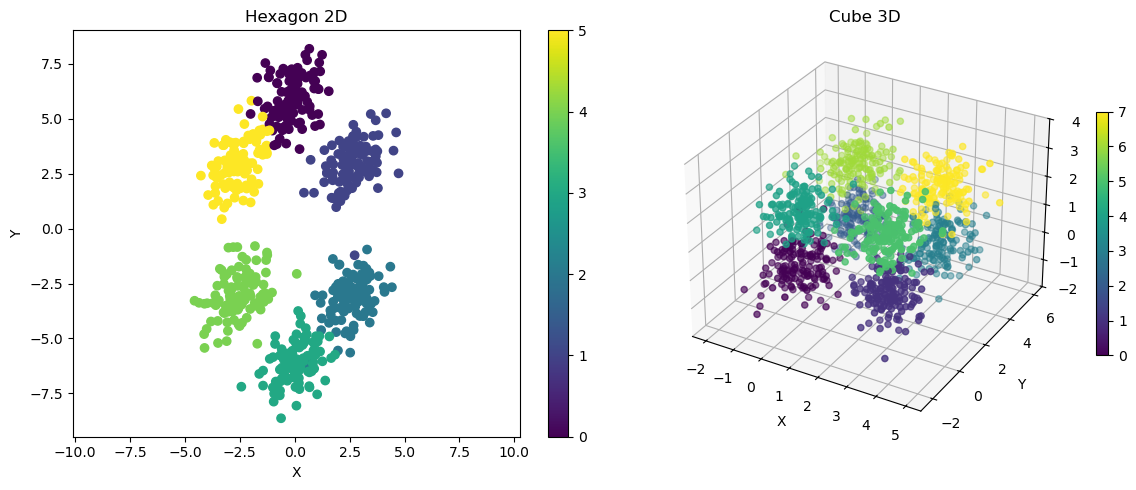

In [3]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
scatter1 = ax1.scatter(hexagon_X[:, 0], hexagon_X[:, 1], c=hexagon_Y.flatten(), cmap='viridis')
fig.colorbar(scatter1, ax=ax1)
ax1.set_title('Hexagon 2D')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.axis('equal')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(cube_X[:, 0], cube_X[:, 1], cube_X[:, 2], c=cube_Y.flatten(), cmap='viridis')
fig.colorbar(scatter2, ax=ax2, shrink=0.6)
ax2.set_title('Cube 3D')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [ ]:
class KohonenMap:
	def gaussian(self, x, sigma):
		return np.exp(-x / (2 * sigma ** 2))
	
	def gaussian_sec(self, x, sigma):
		return (1 - x / (sigma ** 2)) * np.exp(-x / (2 * (sigma ** 2)))

	def __init__(self, map_size, data_dims):
		# initiate map size and random initial weights
		self.map_dims = (map_size[0], map_size[1])
		self.weights = np.random.rand(map_size[0], map_size[1], data_dims)
		self.weights_index = np.array([(i, j) for i in range(map_size[0]) for j in range(map_size[1])])
		# set epsilon for dumping factor
		self.epsilon = np.finfo(float).eps

	def visualize(self, observations, labels, prediction, show_neurons=True):
		labels = labels.ravel()
		prediction_ids = np.ravel_multi_index(prediction.T.astype(int), dims=self.map_dims)

		unique_labels = np.unique(labels)
		unique_predictions = np.unique(prediction_ids)
		cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
		cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))

		print("SOM clusters:", len(unique_predictions))
		print("True clusters:", len(unique_labels))

		fig = plt.figure(figsize=(10, 5))
		is_3d = observations.shape[1] == 3

		# Plot 1: Original Labels
		ax1 = fig.add_subplot(1, 2, 1, projection='3d' if is_3d else None)
		for i, label in enumerate(unique_labels):
			idx = labels == label
			ax1.scatter(*observations[idx].T, color=cmap_labels(i), label=f'Class {label}')
		ax1.set_title('Original Labels')
		ax1.set_xlabel('X')
		ax1.set_ylabel('Y')
		if is_3d:
			ax1.set_zlabel('Z')

		# Plot 2: SOM Predictions + Neuron positions
		ax2 = fig.add_subplot(1, 2, 2, projection='3d' if is_3d else None)
		for i, cluster in enumerate(unique_predictions):
			idx = prediction_ids == cluster
			ax2.scatter(*observations[idx].T, color=cmap_predictions(i))
		
		if show_neurons:
			# Flatten weights for scatter
			flat_weights = self.weights.reshape(-1, observations.shape[1])
			ax2.scatter(*flat_weights.T, marker='x', color='black', label='Neurons')

		ax2.set_title('SOM Predictions')
		ax2.set_xlabel('X')
		ax2.set_ylabel('Y')
		if is_3d:
			ax2.set_zlabel('Z')
		ax2.legend()
		plt.tight_layout()
		plt.show()
		
	def visualize_old(self, observations, labels, prediction):
		labels = labels.ravel()
		prediction_ids = np.ravel_multi_index(prediction.T.astype(int), dims=self.map_dims)

		unique_labels = np.unique(labels)
		unique_predictions = np.unique(prediction_ids)
		cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
		cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))

		print("SOM clusters:", len(unique_predictions))
		print("True clusters:", len(unique_labels))

		if observations.shape[1] == 2:
			fig = plt.figure(figsize=(10, 5))
			ax1 = fig.add_subplot(1, 2, 1)
			for i, label in enumerate(unique_labels):
				idx = labels == label
				ax1.scatter(observations[idx, 0], observations[idx, 1], color=cmap_labels(i))
			ax1.set_title('Original Labels')
			ax1.set_xlabel('X')
			ax1.set_ylabel('Y')

			ax2 = fig.add_subplot(1, 2, 2)
			for i, cluster in enumerate(unique_predictions):
				idx = prediction_ids == cluster
				ax2.scatter(observations[idx, 0], observations[idx, 1], color=cmap_predictions(i))
			ax2.set_title('SOM Predictions')
			ax2.set_xlabel('X')
			ax2.set_ylabel('Y')

		elif observations.shape[1] == 3:
			fig = plt.figure(figsize=(10, 5))
			ax1 = fig.add_subplot(1, 2, 1, projection='3d')
			for i, label in enumerate(unique_labels):
				idx = labels == label
				ax1.scatter(observations[idx, 0], observations[idx, 1], observations[idx, 2],
							color=cmap_labels(i))
			ax1.set_title('Original Labels')
			ax1.set_xlabel('X')
			ax1.set_ylabel('Y')
			ax1.set_zlabel('Z')

			ax2 = fig.add_subplot(1, 2, 2, projection='3d')
			for i, cluster in enumerate(unique_predictions):
				idx = prediction_ids == cluster
				ax2.scatter(observations[idx, 0], observations[idx, 1], observations[idx, 2],
							color=cmap_predictions(i))
			ax2.set_title('SOM Predictions')
			ax2.set_xlabel('X')
			ax2.set_ylabel('Y')
			ax2.set_zlabel('Z')

		plt.tight_layout()
		plt.show()

	def learn(self, observations, iterations_num, step=None, map_range=None, influence_func='gaussian'):
		# set hyper parameters if not given
		if step is None:
			step = 0.1
		if map_range is None:
			map_range = np.min(self.map_dims) // 2
		
		# set dumping factor
		self.dumping_factor = len(observations)/np.log(map_range + self.epsilon)

		# perform learning
		for iteration in range(iterations_num):
			# go over data
			for time, observation in enumerate(observations):
				# check all errors
				error = self.check_error(observation)
				# pick smallest error
				bmu = self.check_BMU(error)
				# find distances to bmu
				distance = self.check_distance(bmu)
				# find update overflow from bmu 
				if influence_func == 'gaussian':
					influence = self.gaussian(distance, map_range)
				if influence_func == 'gaussian_sec':
					influence = self.gaussian_sec(distance, map_range)
				# update weights
				self.weights += step * influence[:,:,np.newaxis] * error

			# update hyper parameters
			map_range, step = self.check_parameters(time, map_range, step)
			# print('time', time)
			# print('map_range', map_range)
			# print('step', step)

	def check_distance(self, bmu):
		# check distances in map coordinates from the given neuron 
		distance = np.linalg.norm(bmu - self.weights_index, axis=1).reshape(self.map_dims)
		return distance

	def check_error(self, observation):
		# check error between neurons and data
		error = observation - self.weights
		return error
		
	def check_BMU(self, error):
		# find coordinates of neuron most simmilar to observation
		similarity = np.linalg.norm(error, axis=-1)
		bmu = np.array(np.unravel_index(np.argmin(similarity), similarity.shape))
		return bmu
	
	def check_parameters(self, time, map_range, step):
		# update range modifier and step size for weights update
		new_range = map_range * np.exp(-time/self.dumping_factor)
		new_step = step * np.exp(-time/self.dumping_factor)
		return new_range, new_step
	
	def predict(self, observations):
		# cluster data based on current weights
		clasters = np.empty((len(observations), 2))
		for time, observation in enumerate(observations):
			error = self.check_error(observation)
			bmu = self.check_BMU(error)
			clasters[time] = bmu
		return clasters

	def get_error_matrix(self, labels, predictions):
		neuron_class_counts = defaultdict(Counter)

		for i, bmu in enumerate(predictions.astype(int)):
			neuron_id = tuple(bmu)
			label = labels[i]
			if isinstance(label, np.ndarray):
				label = label.item()
			neuron_class_counts[label][neuron_id] += 1

		# Convert to DataFrame for readability
		all_labels = sorted(neuron_class_counts.keys())
		all_neurons = sorted({nid for c in neuron_class_counts.values() for nid in c})
		neuron_strs = [str(nid) for nid in all_neurons]

		data = []
		for label in all_labels:
			row = [neuron_class_counts[label].get(nid, 0) for nid in all_neurons]
			data.append(row)

		df = pd.DataFrame(data, index=all_labels, columns=neuron_strs)
		return df


/tmp/ipykernel_970/1491133864.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_970/1491133864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 16
True clusters: 6


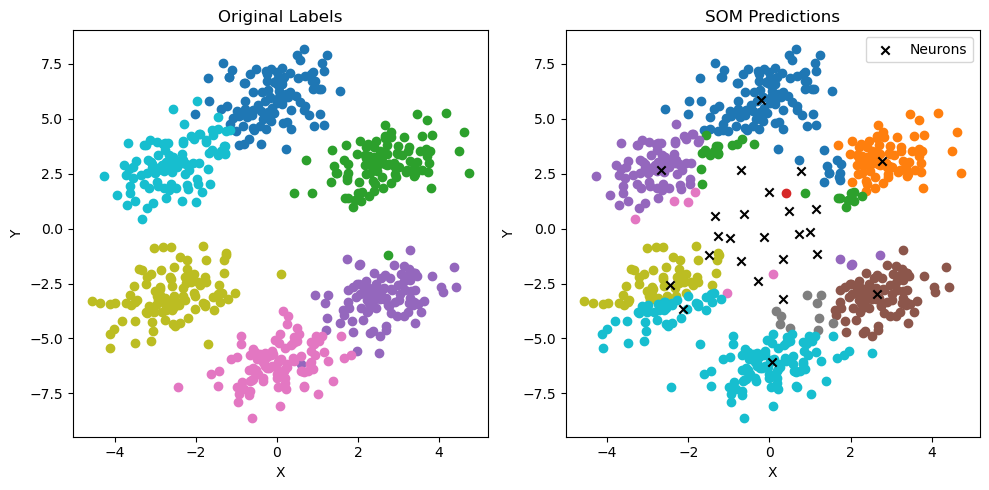

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(0), np.int64(3))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(1), np.int64(4))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(4))","(np.int64(3), np.int64(0))","(np.int64(3), np.int64(3))","(np.int64(3), np.int64(4))","(np.int64(4), np.int64(1))","(np.int64(4), np.int64(2))","(np.int64(4), np.int64(3))","(np.int64(4), np.int64(4))"
0,95,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0
1,0,11,78,9,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,3,0,88,0,0,6,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,96
4,0,0,0,0,0,0,0,0,0,0,2,0,11,44,43,0
5,7,0,0,0,11,0,0,78,0,4,0,0,0,0,0,0


In [98]:
koh_hexagon = KohonenMap(map_size = (5, 5), data_dims = 2)

koh_hexagon.learn(hexagon_X, iterations_num=50, step=0.2, map_range=3, influence_func='gaussian')

prediction_hexagon = koh_hexagon.predict(hexagon_X)

koh_hexagon.visualize(hexagon_X, hexagon_Y, prediction_hexagon, show_neurons=True)

koh_hexagon.get_error_matrix(hexagon_Y, prediction_hexagon)

/tmp/ipykernel_970/1491133864.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_970/1491133864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 12
True clusters: 6


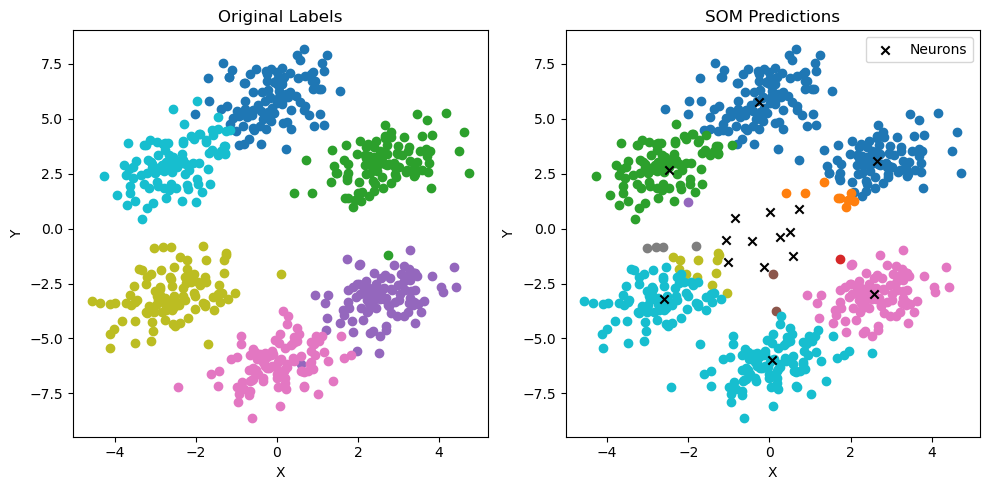

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(3))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(2))","(np.int64(2), np.int64(3))","(np.int64(3), np.int64(0))","(np.int64(3), np.int64(1))","(np.int64(3), np.int64(2))","(np.int64(3), np.int64(3))"
0,99,0,0,1,0,0,0,0,0,0,0,0
1,0,90,9,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,95,0,0,0,4
3,0,0,0,0,0,0,1,0,0,0,0,99
4,0,0,0,0,0,0,1,0,4,12,82,1
5,7,0,0,92,0,1,0,0,0,0,0,0


In [99]:
koh_hexagon = KohonenMap(map_size = (4, 4), data_dims = 2)

koh_hexagon.learn(hexagon_X, iterations_num=50, step=0.2, map_range=3, influence_func='gaussian')

prediction_hexagon = koh_hexagon.predict(hexagon_X)

koh_hexagon.visualize(hexagon_X, hexagon_Y, prediction_hexagon, show_neurons=True)

koh_hexagon.get_error_matrix(hexagon_Y, prediction_hexagon)

/tmp/ipykernel_970/1491133864.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_970/1491133864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 6
True clusters: 6


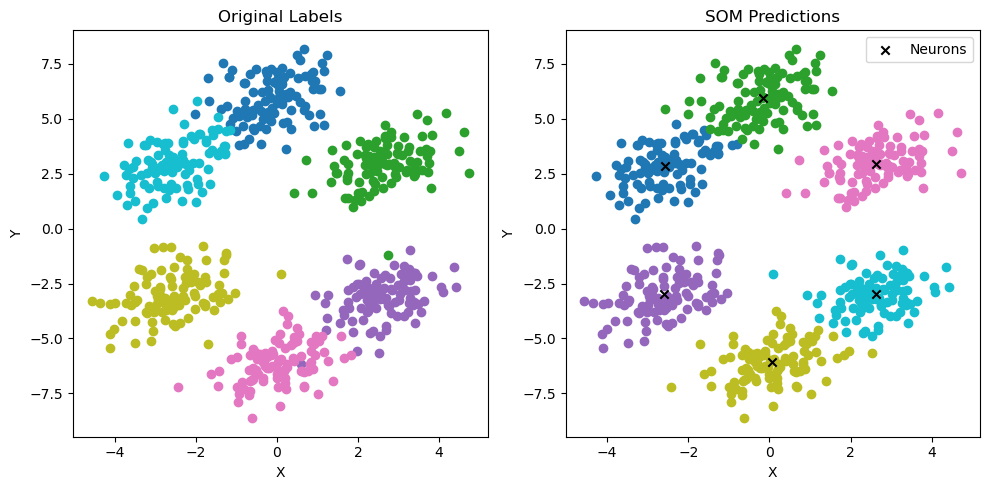

Number of clusters in each bmu:
Neuron (np.int64(0), np.int64(0)): {5: 94, 0: 2}
Neuron (np.int64(0), np.int64(1)): {0: 98, 5: 6}
Neuron (np.int64(1), np.int64(0)): {4: 98}
Neuron (np.int64(1), np.int64(1)): {1: 99}
Neuron (np.int64(2), np.int64(0)): {3: 100, 2: 4, 4: 1}
Neuron (np.int64(2), np.int64(1)): {2: 96, 4: 1, 1: 1}


,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(1))"
0,2,98,0,0,0,0
1,0,0,0,99,0,1
2,0,0,0,0,4,96
3,0,0,0,0,100,0
4,0,0,98,0,1,1
5,94,6,0,0,0,0


In [ ]:
koh_hexagon = KohonenMap(map_size = (3, 2), data_dims = 2)

koh_hexagon.learn(hexagon_X, iterations_num=50, step=0.2, map_range=2, influence_func='gaussian')

prediction_hexagon = koh_hexagon.predict(hexagon_X)

koh_hexagon.visualize(hexagon_X, hexagon_Y, prediction_hexagon, show_neurons=True)

koh_hexagon.get_error_matrix(hexagon_Y, prediction_hexagon)

/tmp/ipykernel_970/1491133864.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_970/1491133864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 24
True clusters: 8


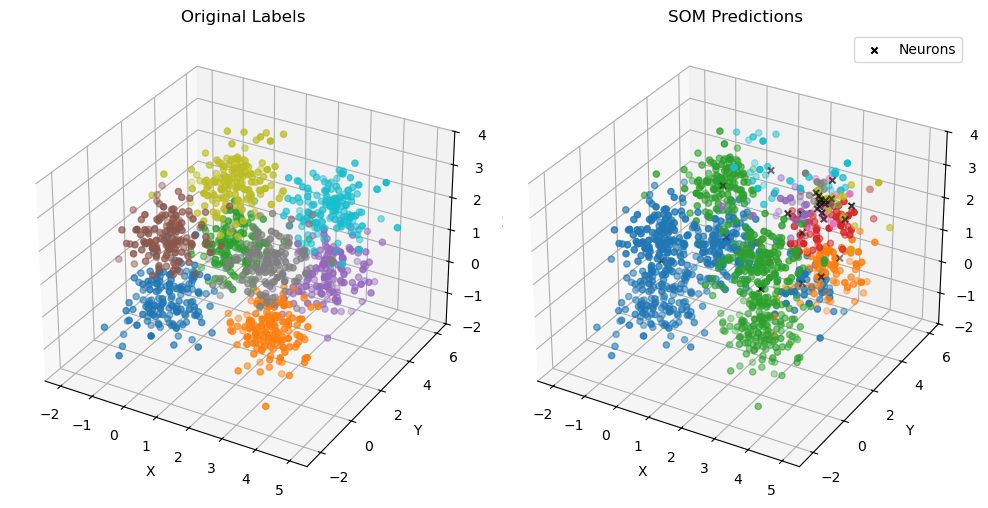

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(0), np.int64(3))","(np.int64(0), np.int64(4))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(1), np.int64(2))","(np.int64(1), np.int64(3))","(np.int64(1), np.int64(4))",...,"(np.int64(2), np.int64(4))","(np.int64(3), np.int64(0))","(np.int64(3), np.int64(1))","(np.int64(3), np.int64(3))","(np.int64(3), np.int64(4))","(np.int64(4), np.int64(0))","(np.int64(4), np.int64(1))","(np.int64(4), np.int64(2))","(np.int64(4), np.int64(3))","(np.int64(4), np.int64(4))"
0,150,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,148,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,143,1,0,0,0,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,51,40,42,0,0,11,2,3,...,1,0,0,0,0,0,0,0,0,0
4,149,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,146,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,11,0,0,0,0,120,0,0,0,...,0,0,0,0,0,0,0,0,0,19
7,0,0,0,3,2,0,0,18,9,19,...,13,8,1,3,10,10,8,5,10,0


In [102]:
koh_cube = KohonenMap(map_size = (5, 5), data_dims = 3)

koh_cube.learn(cube_X, iterations_num=100, step=1, map_range=3, influence_func='gaussian')

prediction_cube = koh_cube.predict(cube_X)

koh_cube.visualize(cube_X, cube_Y, prediction_cube)

koh_hexagon.get_error_matrix(cube_Y, prediction_cube)

/tmp/ipykernel_970/1491133864.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_970/1491133864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 16
True clusters: 8


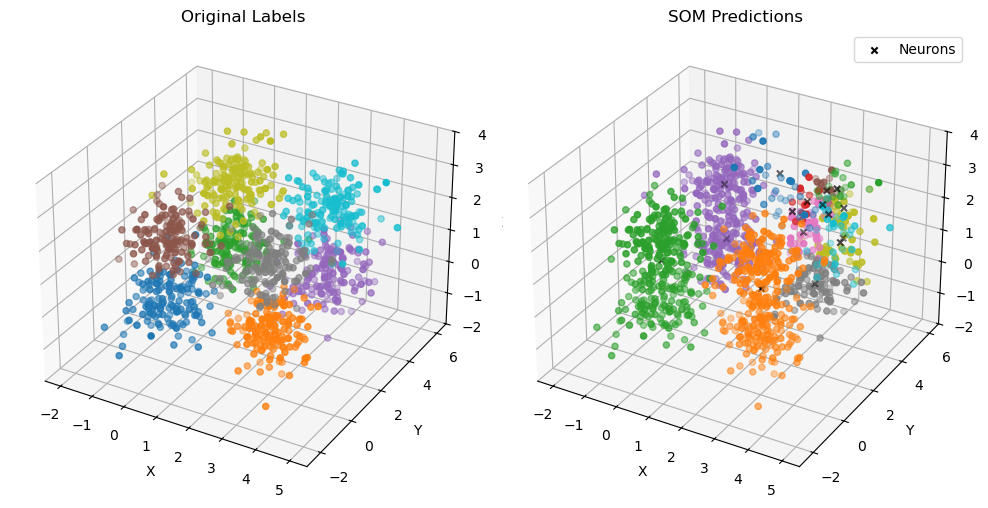

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(0), np.int64(3))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(1), np.int64(2))","(np.int64(1), np.int64(3))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(1))","(np.int64(2), np.int64(2))","(np.int64(2), np.int64(3))","(np.int64(3), np.int64(0))","(np.int64(3), np.int64(1))","(np.int64(3), np.int64(2))","(np.int64(3), np.int64(3))"
0,0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,149,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,3,144,0,0,2,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,14,93,29,0,1,12
4,0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,147,2,0,0,0,0,0,0,0,0,0,0,0,0
6,13,0,0,0,0,0,127,10,0,0,0,0,0,0,0,0
7,3,14,0,0,18,13,0,0,14,16,26,0,7,16,10,13


In [104]:
koh_cube = KohonenMap(map_size = (4, 4), data_dims = 3)

koh_cube.learn(cube_X, iterations_num=300, step=1, map_range=3, influence_func='gaussian')

prediction_cube = koh_cube.predict(cube_X)

koh_cube.visualize(cube_X, cube_Y, prediction_cube)

koh_hexagon.get_error_matrix(cube_Y, prediction_cube)

/tmp/ipykernel_970/1491133864.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_970/1491133864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 8
True clusters: 8


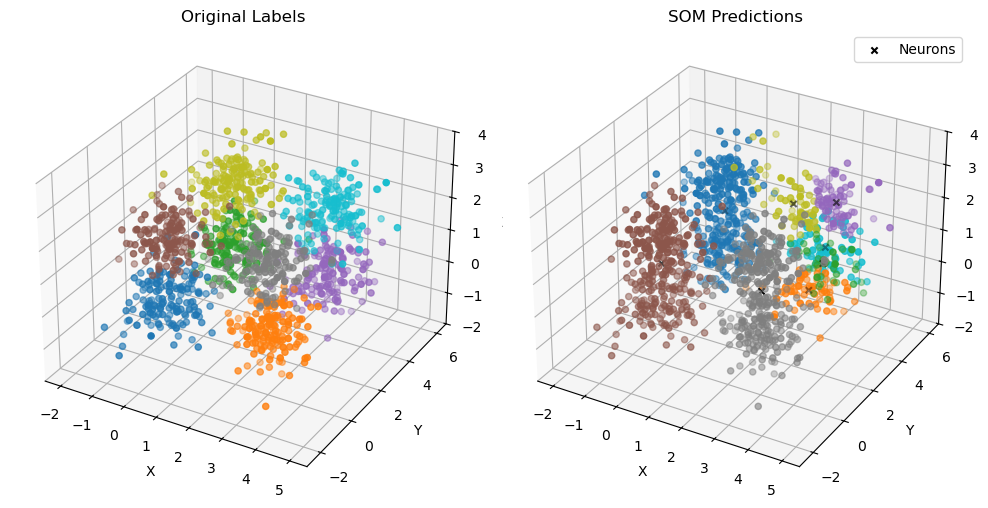

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(0), np.int64(3))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(1), np.int64(2))","(np.int64(1), np.int64(3))"
0,0,0,0,0,150,0,0,0
1,0,1,0,0,0,149,0,0
2,147,1,0,0,0,0,0,2
3,0,64,33,0,0,0,1,52
4,0,0,0,0,150,0,0,0
5,0,0,0,0,2,148,0,0
6,138,0,0,0,0,0,12,0
7,0,0,8,81,0,0,45,16


In [107]:
koh_cube = KohonenMap(map_size = (2, 4), data_dims = 3)

koh_cube.learn(cube_X, iterations_num=200, step=1, map_range=2, influence_func='gaussian')

prediction_cube = koh_cube.predict(cube_X)

koh_cube.visualize(cube_X, cube_Y, prediction_cube)

koh_hexagon.get_error_matrix(cube_Y, prediction_cube)

Jeżeli ilość neuronów w mapie jest większa niż liczba faktycznie obecnych klastrów w danych to sieć Kohonena zawyża ilość klastrów w predykcji. Tylko jeśli znamy z góry ilość klastrów i odpowiednio dostosujemy wielkość siatki wynik się zgadza. Ten efekt jest tym gorszy im bardziej przestrzelimy.

Jeśli do tego dochodzi to poziom mieszania się klastrów w predykcjach jest znaczący. 

Dla zbioru cube nawet przy dobraniu odpowiednij liczby neuronów sieć nie radzi sobie z poprawnym wyznaczeniem klastrów. Wydaje się, że jest to związane z tym że początkowa postać neuronów jest skoncentrowana w jednym z 'rogów' danych i nie są one w stanie zmigrować tak aby poprawnie pokryć wszystkie klastry. Trzy z krawędzi sześcianu są zajęte przez 3 neurony a pozostałe pozostają w rogu gdzie zainicjowane zostały wagi początkowe. Można by to rozwiązać losując wagi wokuł środka masy obserwacji.